<a href="https://colab.research.google.com/github/kkostromin/sber_ds/blob/main/CV_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

С помощью CNN решить задачу множественной классификации изображений, в качестве данных использовать датасет CIFAR-10. Добиться точности классификации на тестовой выборке не менее 80% (для полного балла за ДЗ). Провести анализ ошибок - вычислить и построить гистограммы precision и recall для каждого класса, построить графики зависимости ошибок и точности тестовой и обучающей выборок в зависимости от эпох обучения.

**В ДЗ можно пользоваться кодом из лекции**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torch.nn.functional as func 
from collections import defaultdict
import time
from torchsummary import summary
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import torchvision
from torchvision import transforms

device_num = 0
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda:0


In [2]:
!nvidia-smi

Wed Dec  7 16:12:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

2) **Загрузите датасет и разбейте его на train и test**

In [3]:
# # загружаем тренировочный датасет CIFAR10
# dataset = torchvision.datasets.CIFAR10(
#     root='./data', 
#     train=True,
#     download=True, 
#     transform=torchvision.transforms.ToTensor()
# )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [2]:
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)
# разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [40000, 10000]
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_dataset = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_dataset = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_batch_gen = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size,
    sampler=train_sampler, num_workers=num_workers)
val_batch_gen = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_idx), len(test_dataset), len(valid_idx)

(40000, 10000, 10000)

In [4]:
#Обратите внимание что теперь 10 уникальных классов (не 2 как в лекции)
print(np.unique(dataset.targets))

[0 1 2 3 4 5 6 7 8 9]


In [70]:
#Размер всего датасета
print(dataset.data.shape)

(50000, 32, 32, 3)


In [5]:
#hidden_sizes = [128, 256, 256]
# batch_size = 64
input_size = 28 * 28
num_classes = 10
#lr = 0.001
#num_epochs = 10
dropout_rate = 0.1

In [75]:
batch_size = 30

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# **Cоздайте класс сети**

In [6]:
class MyCNN_2(nn.Module):
  def __init__(self, num_classes, input_size, hidden_sizes, dropout_rate=0.1):
    super().__init__()
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(input_size, hidden_sizes[0])
    self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
    self.dropout1 = nn.Dropout(dropout_rate)

    self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
    self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
    self.dropout2 = nn.Dropout(dropout_rate)

    self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
    self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
    self.dropout3 = nn.Dropout(dropout_rate)

    self.fc_final = nn.Linear(hidden_sizes[2], num_classes)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.flatten(x)
    
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.dropout1(x)
    x = self.relu(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = self.dropout2(x)
    x = self.relu(x)

    x = self.fc3(x)
    x = self.bn3(x)
    x = self.dropout3(x)
    x = self.relu(x)

    x = self.fc_final(x)
    x = self.softmax(x)
    return x

# Prepare data

In [71]:
len(train_dataset), len(test_dataset), len(val_dataset)

(50000, 10000, 10000)

In [13]:
#train_loader = DataLoader(train_dataset, batch_size=batch_size)
#test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
# for item, label in train_loader:
#   print(item.shape, label.shape)
#   break

# Create Net Class

In [18]:
class CNN(nn.Module):
   
    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2), # +0.05

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),  #+0.05

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2) #+++++
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.2), #0.1
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2), #0.1
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

#criterion & optimizer

In [19]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters())

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.001)

#Train

In [11]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [12]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=60
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                logits = model(X_batch)
                
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, val_loss))
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

#Run model

Epoch 30 of 30 took 24.263s
  training loss (in-iteration): 	0.625020
  validation loss (in-iteration): 	0.636620
  training accuracy: 			78.00 %
  validation accuracy: 			77.66 %


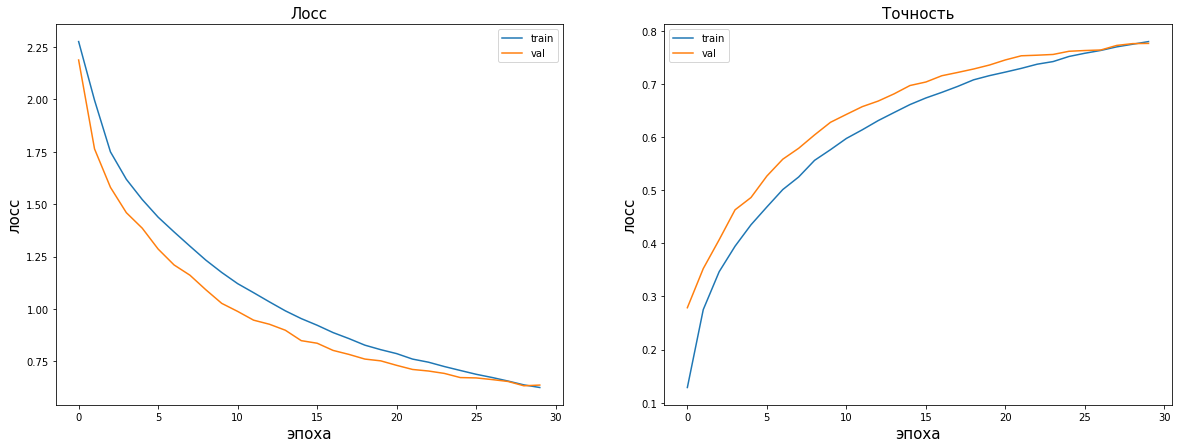

In [20]:
model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs = 30
)

In [21]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
    for X_batch, y_batch test_batch_gen:
    # move tensors to GPU if CUDA is available
    #if train_on_gpu:
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_batch_gen.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
     

TypeError: ignored

*batch_size = 20 : *
Epoch 16 of 30 took 20.734s
  training loss (in-iteration): 	0.532710
  validation loss (in-iteration): 	0.710816
  training accuracy: 			81.31 %
  validation accuracy: 			75.51 %

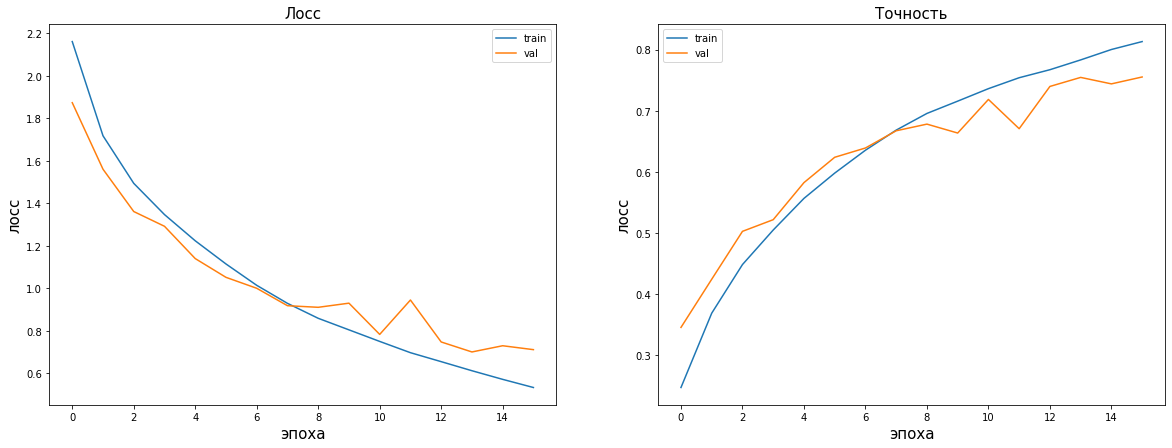

*batch_size = 20, 
valid_size = 0.3
 -> Epoch 17 of 30 took 17.371s
  training loss (in-iteration): 	0.551647
  validation loss (in-iteration): 	0.728188
  training accuracy: 			80.62 %
  validation accuracy: 			75.05 %
  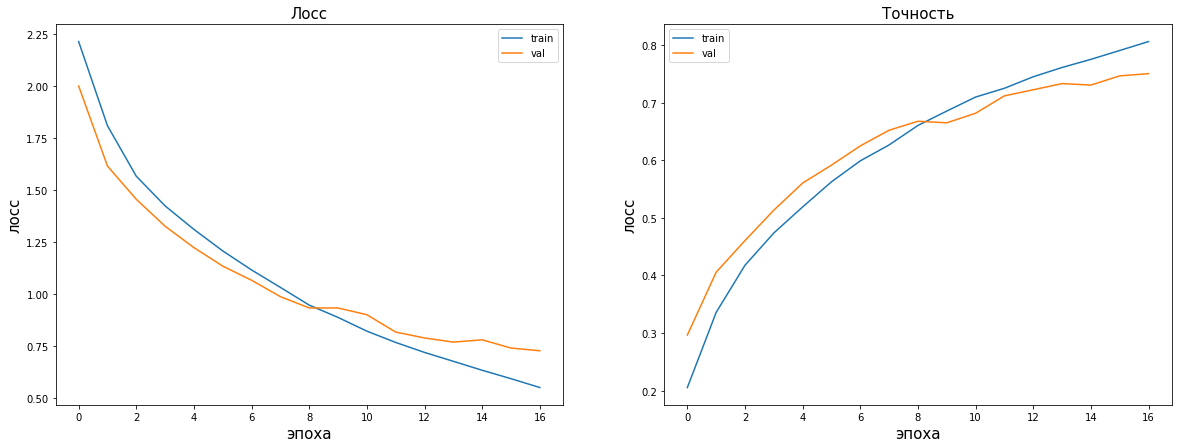

*batch_size = 30
valid_size = 0.2
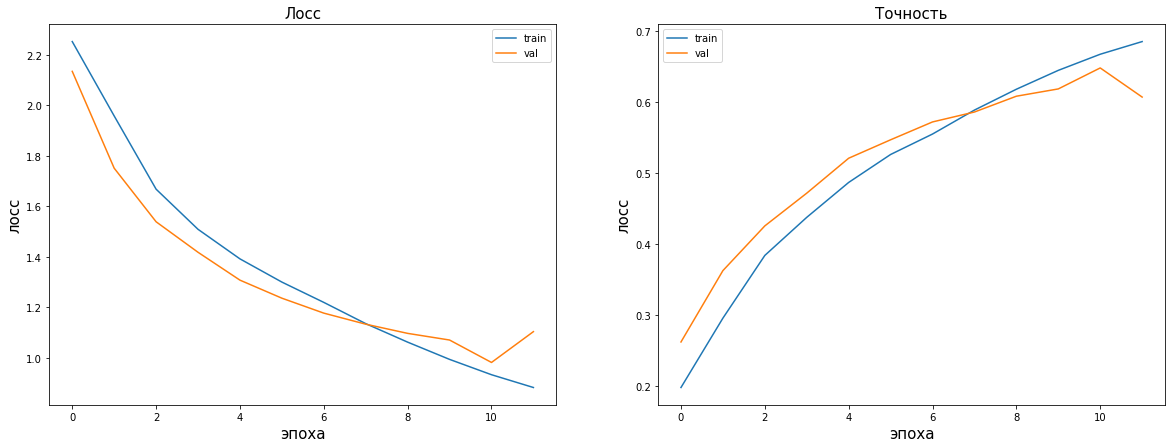


normolise: 

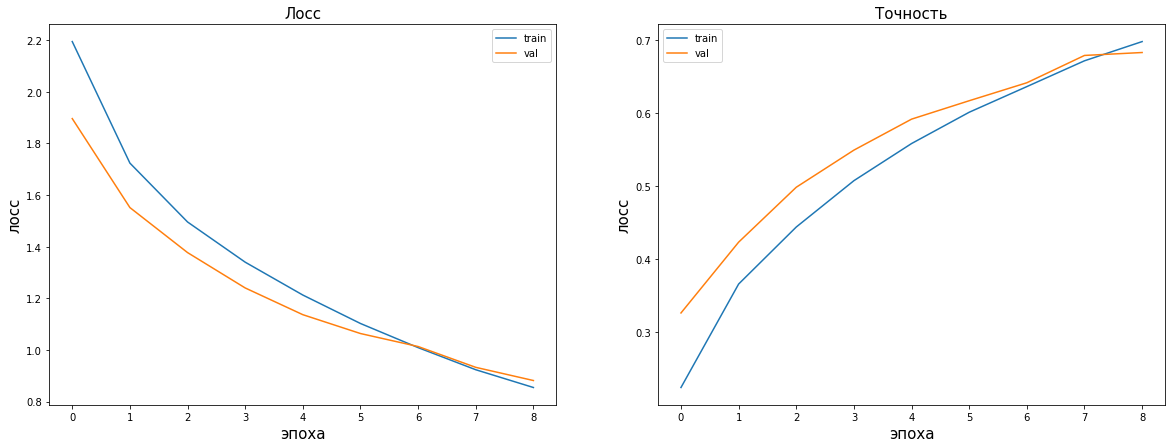

dropout: p=0,05

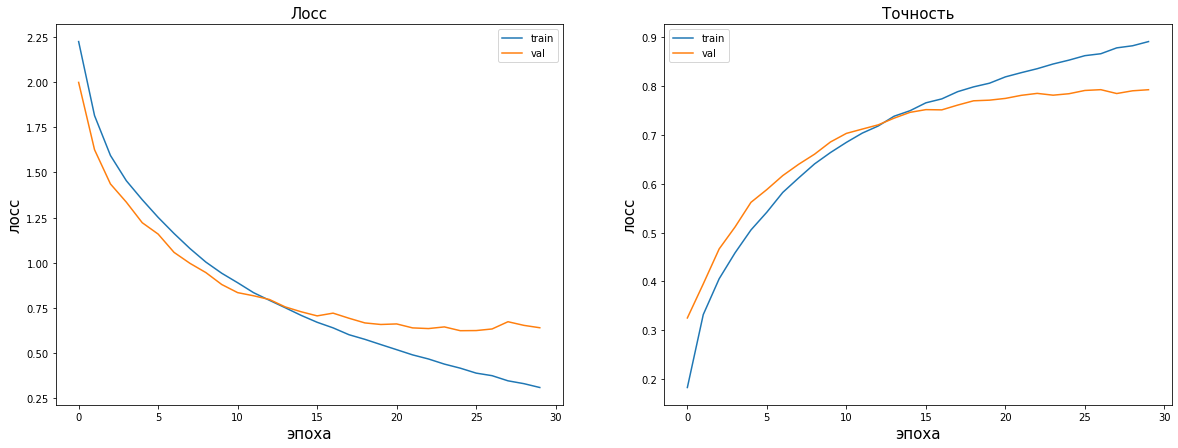


dropout p = 0.1
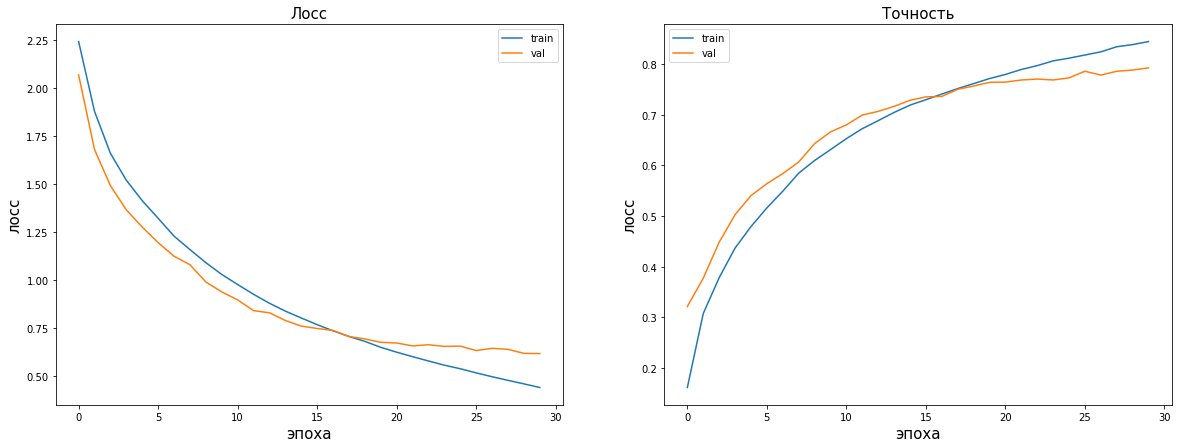

dropout p = 0.2
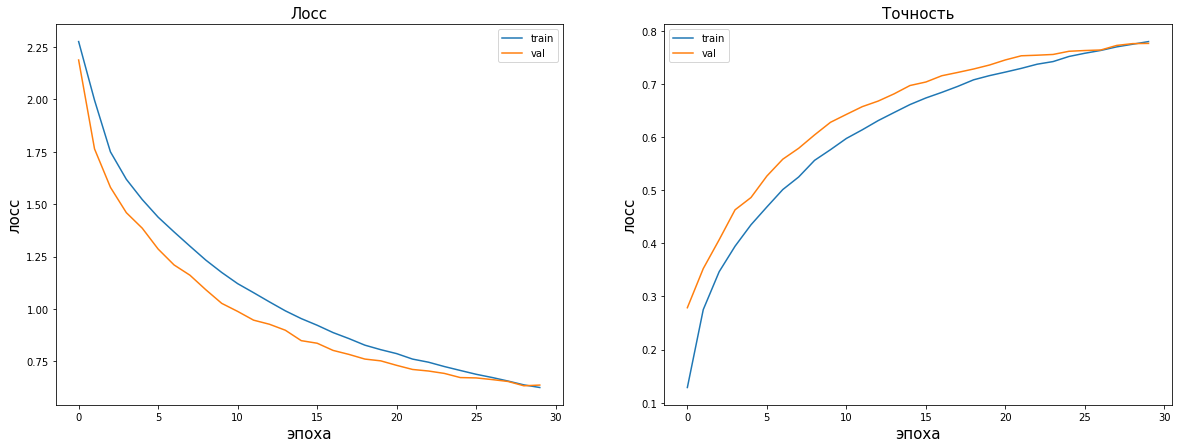

4) **Построите графики обучения и проанализируйте ошибки сети, сделайте выводы**

In [ ]:
# your code here

# Hint: графики необходимы для того, чтобы следить за тем, не переобучилась ли модель
# в случае переобучения можно попробовать изменить размер сети, добавить слои batchnorm и dropout